In [1040]:
%matplotlib inline
import networkx as nx
import community
import numpy as np
import matplotlib.pylab as plt
import sys
from collections import Counter, defaultdict
from random import choice
from sklearn.metrics.cluster import normalized_mutual_info_score
from ulf import ulf, tmpnets
import seaborn as sns
from sklearn import gaussian_process
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
reload(ulf)
reload(tmpnets)

<module 'ulf.tmpnets' from '/usr/local/lib/python2.7/site-packages/ulf/tmpnets.pyc'>

In [3]:
G0 = nx.fast_gnp_random_graph(20, 0.2)
GC = clustered_random_graph(G0, AvgClustering(), 0.2)[0]

In [8]:
def draw(G, partition="teal"):
    if partition == True:
        partition = community.best_partition(G).values()
    pos = nx.nx_pydot.graphviz_layout(G, prog='neato')
    nx.draw_networkx_nodes(G, pos=pos, node_size=50, alpha=1.0, linewidths=0, node_color=partition)
    nx.draw_networkx_edges(G, pos=pos, width=1, alpha=.3)
    plt.axis("off")

NETWORK_SIZE = 100
K = 2
P = 1
G0 = nx.powerlaw_cluster_graph(NETWORK_SIZE, K, P)

for n, k in sorted(G0.degree().items(), key=lambda k: k[1], reverse=True)[:8]:
    G0.remove_node(n)
    
for n, k in G0.degree().items():
    if k == 0:
        G0.remove_node(n)

# partition = community.best_partition(G0).values()
# num_partitions = len(set(partition))

# degree_distribution = sorted(G0.degree().items(), key=lambda (k, v): v, reverse=True)
# for i in range(0):

#     G0.remove_node(degree_distribution[i][0])

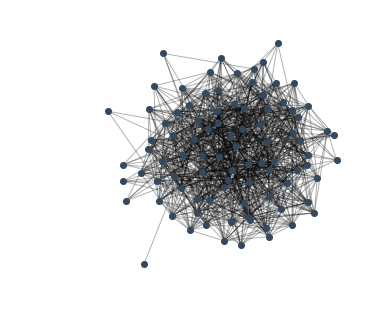

In [5]:
# Hairball
NETWORK_SIZE = 100
K = 20
P = 0.8
G0 = nx.powerlaw_cluster_graph(NETWORK_SIZE, K, P)
for n, k in sorted(G0.degree().items(), key=lambda k: k[1], reverse=True)[:8]:
    G0.remove_node(n)
for n, k in G0.degree().items():
    if k == 0: G0.remove_node(n)

fig = plt.figure(figsize=(6,5))
draw(G0, partition="#34495e")
#plt.savefig("../presentation/netscix_ignite/figures/network_hairball.pdf")
plt.show()
#plt.close(fig)

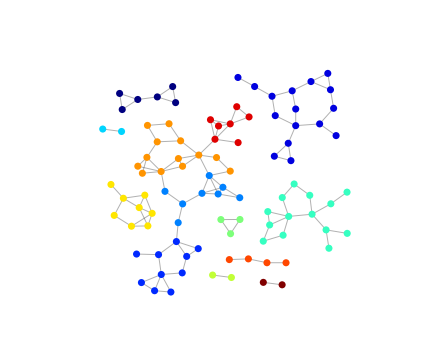

In [95]:
# Timesteps
cut_nodes = 15
NETWORK_SIZE = 104
K = 3
P = 1
G0 = nx.powerlaw_cluster_graph(NETWORK_SIZE + cut_nodes, K, P)
for n, k in sorted(G0.degree().items(), key=lambda k: k[1], reverse=True)[:cut_nodes]:
    G0.remove_node(n)
for n, k in G0.degree().items():
    if k == 0: G0.remove_node(n)

fig = plt.figure(figsize=(6,5), frameon=False)
partition = community.best_partition(G0).values()
draw(G0, partition=partition)
plt.tight_layout()
plt.show()

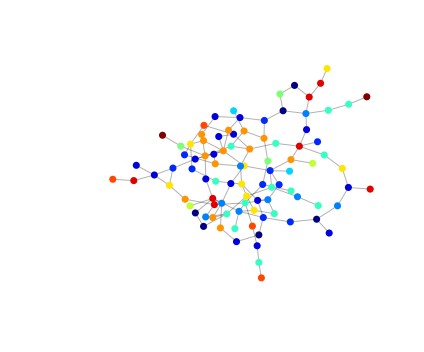

In [293]:
def _independent_edge_swaps(G, num_swaps):
    for _ in range(num_swaps):
        nx.double_edge_swap(G, 1)
    return G

fig = plt.figure(figsize=(6,5), frameon=False)
#draw(G0, partition=partition)
draw(_independent_edge_swaps(G0.copy(), 10000), partition=partition)
plt.tight_layout()
plt.show()

In [477]:
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

def temporal_network_with_signal_layer(G_signal, N_signal, N_noise, num_swaps=100):
    """Build temporal network with noise around a signal layer.
    
    Input
    -----
    G_signal : networkx.classes.graph.Graph
    N_signal : int
    N_noise : int
    num_swaps : int
    
    Output
    ------
    out : str
        Temporal network in pajek format
    """
    
    def write_pajek(A, node_labels=None, index_from=0):
        """Return multiplex representation of multiplex network adjacency matrix A

        Providing an adjacency tensor where A[:, :, k] is adjacency matrix of temporal
        layer k, return a pajek format representation of the temporal network which weights interlayer
        edges by state node neighborhood similarity. 

        Parameters
        ----------
        A : numpy.3darray
            3d tensor where each A[:, :, k] is a layer adjacency matrix
        max_trans_prob : float/str
            Cap on interlayer edge weights. 'square' for square penalty.
        power_penalty : int/float
            Power to jaccard similarity betw. state nodes to penalize low similarity
        index_from : int
            From which number to index nodes and layers in pajek format from
        style : bool
            Either 'zigzag', 'vertical', or 'simple'. 'vertical' will give working results but is
            essentially wrong use of Infomap, 'simple' should be possible to use in Infomap but is not
            at this point, so 'zigzag' is preferred because it is an explicit representation of the way
            the network should be represented internally in Infomap.

        Returns
        -------
        out_file : string
            A network string in multiplex format
        intid_to_origid : dict
            Key-value pairs of node integer id and original id
        origid_to_intid : dict
            Reverse of intid_to_origid
        """

        def _write_outfile(A):
            """Write nodes and intra/inter-edges from A and J to string."""
            def __remove_symmetry_A(A):
                A_triu = defaultdict(int)
                for (i, j, k), w in A.items():
                    if j > i:
                        A_triu[(i, j, k)] = w
                return A_triu
            def __write_nodes(outfile):
                outfile += "*Vertices %d" % Nn
                for nid, label in enumerate(nodes):
                    outfile += '\n%d "%s" 1.0' % (nid + index_from, str(label))
                return outfile
            def __write_intra_edges(outfile):
                outfile += "\n*Intra\n# layer node node [weight]"
                for (i, j, k), w in __remove_symmetry_A(A).items():
                    outfile += '\n%d %d %d %f' % (
                        k + index_from,  # layer
                        nodemap[i] + index_from,  # node
                        nodemap[j] + index_from,  # node
                        w                # weight
                    )
                return outfile

            outfile = ""
            outfile = __write_nodes(outfile)
            outfile = __write_intra_edges(outfile)

            return outfile

        nodes = sorted(set([n for i, j, _ in A.keys() for n in [i, j]]))
        Nn = len(nodes)
        Nl = len(set([k for i, j, k in A.keys()]))

        nodemap = dict(zip(nodes, range(Nn)))

        return _write_outfile(A)

    def _create_adjacency_matrix(layer_edges):
        """Return 3d adjacency matrix of the temporal network.
        
        Input
        -----
        layer_edges : dict
        
        Output
        ------
        A : dict
        """
        A = defaultdict(int)
        for l, edges in layer_edges.items():
            for edge in edges:
                    A[(edge[0], edge[1], l)] += 1
                    A[(edge[1], edge[0], l)] += 1    
        return A
    
    def _independent_edge_swaps(G, num_swaps):
        for _ in range(num_swaps):
            nx.double_edge_swap(G, 1)
        return G
    
    layer_edges = dict(
        (l, _independent_edge_swaps(G_signal.copy(), num_swaps).edges())
        for l in range(N_signal + N_noise)
    )
    
    signal_layers = []
    for _ in range(N_signal):
        l = choice(layer_edges.keys())
        signal_layers.append(l)
        layer_edges[l] = G_signal.edges()
    
    return write_pajek(_create_adjacency_matrix(layer_edges)), signal_layers

def average_non_signal_NMI(layer_commu):
    partitions = defaultdict(dict)
    for l in layer_commu.keys():
        for c, nodes in layer_commu[l].items():
            for n in nodes:
                partitions[l][int(n)] = c

    similarity = np.zeros((len(partitions), len(partitions)))
    for l1 in sorted(layer_commu.keys()):
        partition1 = list(zip(*sorted(partitions[l1].items(), key=lambda x: x[0]))[1])
        for l2 in sorted(layer_commu.keys()):
            partition2 = list(zip(*sorted(partitions[l2].items(), key=lambda x: x[0]))[1])
            similarity[l1, l2] = normalized_mutual_info_score(partition1, partition2)

    return np.mean([
        np.mean(similarity[sl, list(set(range(similarity.shape[0])) - set(signal_layers))])
        for sl in signal_layers
    ])

def gen_G(network_size=100, K=3, P=1, cut_nodes=15):
    G = nx.powerlaw_cluster_graph(NETWORK_SIZE + cut_nodes, K, P)
    for n, k in sorted(G.degree().items(), key=lambda k: k[1], reverse=True)[:cut_nodes]:
        G.remove_node(n)
    for n, k in G.degree().items():
        if k == 0: G.remove_node(n)
    return G

In [1206]:
X, Y1, Y2 = [], [], []
for _ in range(100):
    G = gen_G()
    x, y1, y2 = [], [], []
    for num_swaps in sorted(set([int(num_swaps) for num_swaps in np.logspace(0.1, 3, 50, base=10)])):
        temporal_network, signal_layers = temporal_network_with_signal_layer(G, 2, 10, num_swaps)

        _, layer_commu_pred_all = tmpnets.Infomap(
            temporal_network,
            'output/',
            '-i',
            'multiplex',
            '--multiplex-relax-rate', '0.25',
            '--overlapping',
            '--expanded',
            '--clu',
            '--pajek',
            '--two-level',
            '-z'
        )

        _, layer_commu_pred_js15 = tmpnets.Infomap(
            temporal_network,
            'output/',
            '-i',
            'multiplex',
            '--multiplex-js-relax-rate', '0.25',
            '--overlapping',
            '--expanded',
            '--clu',
            '--pajek',
            '--two-level',
            '-z'
        )

        x.append(num_swaps)
        y1.append(average_non_signal_NMI(layer_commu_pred_all))
        y2.append(average_non_signal_NMI(layer_commu_pred_js15))

        print num_swaps,
    print
    X.append(x)
    Y1.append(y1)
    Y2.append(y2)

1 2 3 4 5 6 7 8 9 11 12 14 16 19 22 25 28 33 37 43 49 57 65 75 86 98 112 129 148 170 194 223 255 293 336 385 441 505 579 664 761 872 1000
1 2 3 4 5 6 7 8 9 11 12 14 16 19 22 25 28 33 37 43 49 57 65 75 86 98 112 129 148 170 194 223 255 293 336 385 441 505 579 664 761 872 1000
1 2 3 4

KeyboardInterrupt: 

In [1210]:
np.mean(np.array(X), axis=0)

array([    1.,     2.,     3.,     4.,     5.,     6.,     7.,     8.,
           9.,    11.,    12.,    14.,    16.,    19.,    22.,    25.,
          28.,    33.,    37.,    43.,    49.,    57.,    65.,    75.,
          86.,    98.,   112.,   129.,   148.,   170.,   194.,   223.,
         255.,   293.,   336.,   385.,   441.,   505.,   579.,   664.,
         761.,   872.,  1000.])

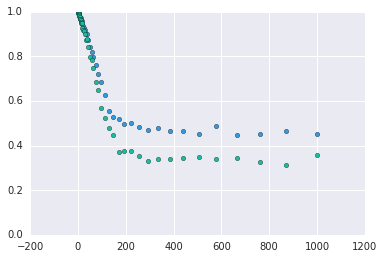

In [1224]:
plt.figure()
plt.scatter(np.mean(np.array(X), axis=0), np.mean(np.array(Y1), axis=0), c="#3498db")
plt.errorbar(np.mean(np.array(X), axis=0), np.mean(np.array(Y1), axis=0), yerr=np.std(np.array(Y1), axis=0) / np.sqrt(len(X)), c="#3498db", lw=0)

plt.scatter(np.mean(np.array(X), axis=0), np.mean(np.array(Y2), axis=0), c="#1abc9c")
plt.errorbar(np.mean(np.array(X), axis=0), np.mean(np.array(Y2), axis=0), yerr=np.std(np.array(Y2), axis=0) / np.sqrt(len(X)), c="#3498db", lw=0)

plt.ylim(0, 1)
plt.show()

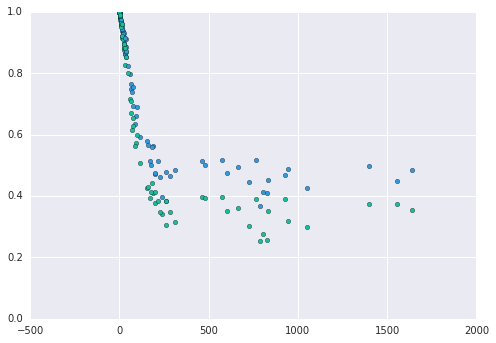

In [794]:
plt.figure()
for x, y1, y2 in zip(X, Y1, Y2):
    plt.scatter(x, y1, c="#3498db")
    plt.scatter(x, y2, c="#1abc9c")
plt.ylim(0, 1)
plt.show()

In [1034]:
def add_noise(v, factor):
    return v + ((np.random.random() - 0.5) * 2) * factor

X_ = np.array([add_noise(v, 0.001) for x in X for v in x]).reshape((-1, 1))
Y1_ = np.array([add_noise(v, 0.001) for x in Y1 for v in x])
Y2_ = np.array([add_noise(v, 0.001) for x in Y2 for v in x])
gp = gaussian_process.GaussianProcess(theta0=1e-2, thetaL=1e-3, thetaU=1e-2, nugget=1e-10)
gp.fit(X_, Y1_)
X_linspace = np.linspace(int(min(X_)), int(max(X_)), 100).reshape((-1, 1))
Y1_pred, sigma2_pred1 = gp.predict(X_linspace, eval_MSE=True)
gp.fit(X_, Y2_)
Y2_pred, sigma2_pred2 = gp.predict(X_linspace, eval_MSE=True)

/usr/local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GaussianProcess is deprecated; GaussianProcess was deprecated in version 0.18 and will be removed in 0.20. Use the GaussianProcessRegressor instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function l1_cross_distances is deprecated; l1_cross_distances was deprecated in version 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function l1_cross_distances is deprecated; l1_cross_distances was deprecated in version 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


In [1188]:
def add_noise(v, factor):
    return v + ((np.random.random() - 0.5) * 2) * factor

X_ = np.array([add_noise(v, 0.001) for x in X for v in x]).reshape((-1, 1))
Y1_ = np.array([add_noise(v, 0.001) for x in Y1 for v in x])
Y2_ = np.array([add_noise(v, 0.001) for x in Y2 for v in x])

X_linspace = np.linspace(int(min(X_)), int(max(X_)), 100).reshape((-1, 1))

kernel = C(1.0, (1e-3, 1e0)) * RBF(1.0, (1e3, 1e5))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)

gp.fit(X_, Y1_)
Y1_pred, sigma_pred1 = gp.predict(X_linspace, return_std=True)

gp.fit(X_, Y2_)
Y2_pred, sigma_pred2 = gp.predict(X_linspace, return_std=True)



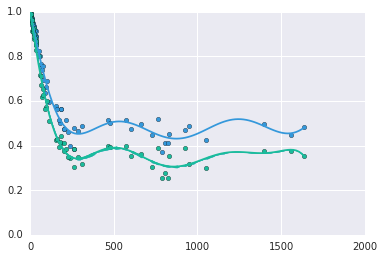

In [1189]:
plt.figure()
plt.scatter(X_, Y1_, c="#3498db")
plt.plot(X_linspace, Y1_pred, c="#3498db")
plt.fill_between(X_linspace.reshape((1, -1))[0], Y2_pred + sigma_pred2, Y2_pred - sigma_pred2, color="#3498db")
plt.scatter(X_, Y2_, c="#1abc9c")
plt.plot(X_linspace, Y2_pred, c="#1abc9c")
plt.fill_between(X_linspace.reshape((1, -1))[0], Y2_pred + sigma_pred2, Y2_pred - sigma_pred2, color="#1abc9c")
plt.ylim(0, 1)
plt.xlim(0)
plt.show()

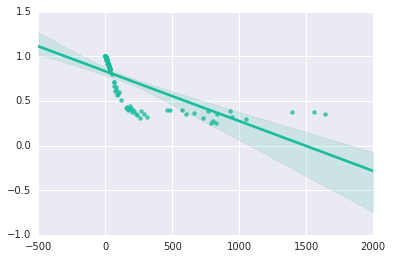

In [1193]:
sns.regplot(X_, Y2_, color="#1abc9c")b

In [ ]:
sns.

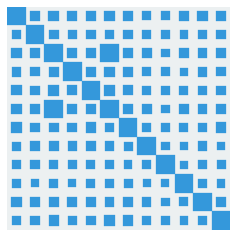

In [1030]:
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))
    
    ax.patch.set_facecolor('#ecf0f1')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = '#3498db' if w > 0 else '#d35400'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

plt.figure()
hinton(similarity)
plt.show()

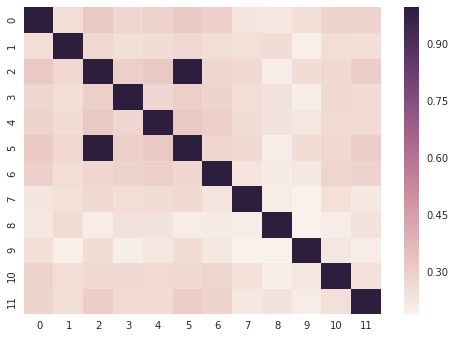

In [406]:
sns.heatmap(similarity)